# Transformer

几乎从2021年底起就不停的听到这个名字，而且自己自我介绍和面试的时候也总是和老师说自己知道transformer，自以为看了一点知乎微信公众号就可以糊弄过去，最后骗的其实是自己  
**Attention is All You Need** *aka* **AAYN** 看起来在数学界已经成了一个梗（    
![](https://miro.medium.com/v2/resize:fit:760/format:webp/1*2vyKzFlzIHfSmOU_lnQE4A.png)

## Embedding and Positional Embedding

Word Embedding 已经是标准操作，经典的操作是word2vec（如果有机会希望可以自己写一写，不过我要学的恐怕太多太多了？）  
Position Embedding 是很有意思的操作，Transformer本身作为 $f$ 是满足对称性（假装看不见target mask，我是小虾子啦啦啦啦~）的，也即 $f(x,y)=f(y,x)$ 这意味“我是你爹”和“你是我爹”输入到模型，给出的输出将是一样的，这是不可接受的，因此我们要打破这种不对称性，从论坛里的讨论来看，这种*broken symmetric*的操作在物理研究中是常见操作  
这个问题在RNN中是不存在的，因为序列中元素的对换至少意味着它们将以不同的先后顺序影响隐状态，因此RNN在结构上就是 *broken symmetric* 的，但是Transformer的KQV Attention就是对称的，Transformer的设计者从非结构的角度出发，通过Alter Input来实现了对对称性的打破，也就是为input加上一个position_embedding  
通过 $f(x+p,y+q) \ne f(y+p,x+q)$ 打破了对称性，同时他们选择position embedding函数还具有距离增大值减小等与语义直觉相符合的特性    
更多数学说明可以看到这里 https://kexue.fm/archives/8231  
word embedding已经集成到nn模块里了，position embedding咱们自己写写      

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import math

# 本质上是一个矩阵，每行对应着一个one-hot的嵌入值，这个嵌入值表会随着反向传播一起更新
class WordEmbedder(nn.Module): 
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size,embedding_dim=d_model)
    def forward(self, x):
        return self.embed(x)
    
class PositionEmbedder(nn.Module):
    def __init__(self, d_model: int, max_seq_len: int = 100):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        pe = torch.zeros([max_seq_len, d_model])
        for pos in range(max_seq_len):
            for i in range(d_model, 2):
                # exp log运算比直接做指数运算更快，损失一点精度换速度（但愿下面这个式子没写错...）
                # self.pe[pos, i] = torch.sin(pos / (10000 ** (i / d_model)))
                pe[pos, i] = torch.sin(pos * torch.exp((-torch.log(10000) * (i / d_model))))
                pe[pos, i+1] = torch.cos(pos * torch.exp(-torch.log(10000) * ((i + 1) / d_model)))
        # 暂时不明白为什么要多加一个维度，用来表示一句话么？
        pe.unsqueeze_(0)
        # position_embedding 不应该参与反向传播
        pe.detach_()
        self.register_buffer('pe',  pe) # 当我们对一个nn.Module调用to(device)时，只有它的parameter()参数Tensor和buffers()缓冲区Tensor会被移动到device，pe不属于paramter，所以我们这里要将pe注册到缓冲区
    
    def forward(self, x):
        # 也可能维度0是batch吧
        seq_len = x.shape[1]
        if seq_len > self.max_seq_len:
            raise ValueError(f"sequence length {seq_len} too large, max seq_len {self.max_seq_len}")
        # TODO 作者这里做了一步对x的放大，理由是为了避免pe太大改变原来的语义，三个问题 1. 为什么要放大，x的值有这么小吗 2.为什么放大的值选择的是sqrt(d_model)
        x = x * math.sqrt(self.d_model)
        x = x + self.pe[:, :seq_len]
        return x

# masker 用途是为我们生成一个个滑动移去遮罩的seq，这对于Decoder很重要，否则decoder会偷看答案
class MaskedSeqGenerator:
    def __init__(self, max_seq_len: int, pad_token_id: int):
        # 生成一个不含对角线的上三角矩阵，然后去反，我们就得到了：
        # 1
        # 1 1
        # 1 1 1 这样的掩码序列，标志着生成序列时每多生成一个，这个生成的结果就被decoder考虑起来 TODO: 其实还是有些没搞懂啊，所以我是做了一次输出，把输出做输入又跑一次模型是么
        self.pad_token_id = pad_token_id
        self.max_seq_len = max_seq_len
        out_mask = torch.ones([max_seq_len, max_seq_len])
        out_mask.triu_(1) # 去掉对角线本身
        self.out_mask = (~(out_mask.bool())).unsqueeze_(0) # 取反，并增加一个batch维度，后面可以直接广播

    def mask_input(self, x: Tensor) -> Tensor:
        seq_len = x.size(1)
        if seq_len > self.max_seq_len:
            raise ValueError(f"sequence length {seq_len} too large, max seq_len {self.max_seq_len}")
        mask = (x != self.pad_token_id).unsqueeze(1) # 增加一个turns维度，后面可以直接广播
        return mask
    
    def mask_target(self, x: Tensor):
        seq_len = x.size(1)
        if seq_len > self.max_seq_len:
            raise ValueError(f"sequence length {seq_len} too large, max seq_len {self.max_seq_len}")
        mask = (x != self.pad_token_id).unsqueeze(1) # 增加一个turns维度，后面可以直接广播
        mask = mask & self.out_mask[:, :seq_len, :seq_len] # 这里mask的维度1 turns会自动广播成需要的轮数，out_mask的batch维度会自动广播成训练数据的batch，从而成为[batch, seq_len, seq_len]
        return mask


**终于来了！著名的Multi-Head Attention！** *虽然现在大家更喜欢用Group Attention了，但是我还是先把Multi-Head给搞清楚吧*  
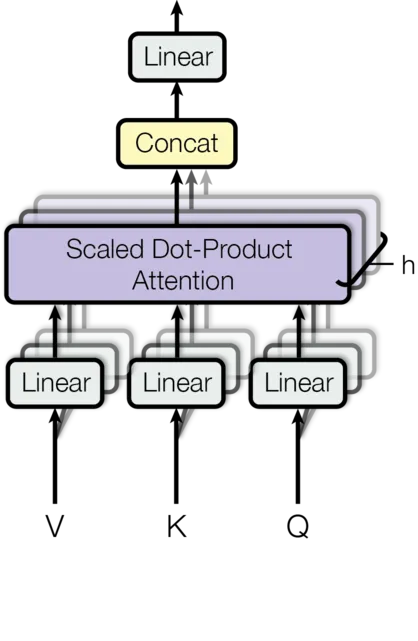   
Attention 的思想机理是希望求出一个权重，这个权重昭示着一个序列中的某个元素对于序列中另一个元素的“注意力”，对于每两个元素都做这件事情，我们就得到一个权重矩阵$W$，其中$w_{ij}$表示元素i对于元素j注意力  
以AAYN中的实现为例，作为一个翻译模型，模型将输入序列$x_1, x_2, ..., x_n$翻译到$y_1, y_2, ..., y_n$，即$Y = f(x)$   
那么输出$y_i$由输入$x_i$对于整个序列元素的注意力和序列元素本身的Embedding Value决定，也就是 $y_i = \sum_{j=1}^{n} w_{ij}v_j$(嘶真的是这样么，那比如中文翻日语可怎么办啊，两种语言文法不一样，$y_i$对应的可能是日语中的宾语，但是$x_i$是中文中的谓语，或许是模型在一层又一层的Attention中自己把这种东西学到了？我感觉我这里还只是理解了一部分encoder，还要看看decoder怎么工作的呢)  
而像GPT-2这样的模型，其目的在于文字接龙，采用的是Transformer decoder架构，因此它其实是一个递归函数$x_{i+1} = f(x_i)$，递归进行直到模型输出一个约定的EOF字符停止或者超出上下文限制导致截断  
输出$x_{i+1}$推导自前i个元素和他们的注意力，也即$x_{i+1} = \sum_{j=0}^{i} w_{ij}v_j$  
上面描述只考虑了Attention 层，实际的实现还加了一些其他的层呢，我慢慢来好咯  
## Attention Mechanism
### 朴素的Attention
我们定义一种最简单的QKV配对机制，简单到QKV就是$x_i$本身  
那么我们可以得到权重矩阵$W = X^TX$（默认元素都是列分布，转置后为行分布）  
这种表示最大的问题是权重矩阵$W$是不可以被反向传播调整的，如果Embedding Value也被detach的话那整个Attention层就不可训练了，所谓的注意力最后完全仰赖Embedding本身，模型自己不能对Embbeding增加自己的理解，这是不能产生好效果的  
### QKV参数化
为此，我们需要将QKV参数化，方法非常简单，我们把$X^T$分别乘上一个(embed_length, hid_dim)矩阵Q、K、V就可以了，这样模型可以在反向传播的时候自己学习怎么从embedding value中抽取Query、Key和Value，我觉得可能Q矩阵用来抽这个词希望注意什么样类型的词，K矩阵用来抽取这个词是什么类型的词，V矩阵用于反映这个词（其实我感觉V矩阵好像不是那么重要诶，非要不可么...哦！q和v的维度可能和embed本身不一致，所以至少需要V做一下转换，然后可能还有点超参数化的福利吧），而且这个本身也很容易实现，一个权重矩阵就是个linear层，无非就是分别过了下三个linear    
### 还有一个讨嫌的问题是——为啥要用Multi-Head？
首先我们要明确Single-Head和Multi-Head的差别到底在哪里，首先我们假设一个single head，它的QKV矩阵对应的隐层维度为hidden_dim，记作h, 输入维度为embed_dim，记作e，那么一层attention做的事情是这样的，其中QKV大小都是(h, e)，X的大小是(e, seq_len)，Q'K'V'的大小为(h, seq_len):  
$$Q' = QX + b_q$$
$$K' = KX + b_k$$
$$V' = VX + b_v$$
$$W = Q'^TK'$$
$$X'^T= WV^T $$  
现在我们将它分成m个head，那么每个head的QKV隐层维度为h/m，一层Attention做的事情是这样的  
$$Q'_1 = Q_1X + b_{q1},\ Q'_2 = Q_2X + b_{q2},\ ...\ Q'_m = Q_nX + b_{qn}$$
$$K'_1 = K_1X + b_{k1},\ K'_2 = K_2X + b_{k2},\ ...\ K'_m = K_nX + b_{kn}$$
$$V'_1 = V_1X + b_{v1},\ V'_2 = V_2X + b_{q2},\ ...\ V'_m = V_nX + b_{vn}$$
$$W_1 = Q'^T_1K'_1,\ W_2 = Q'^T_2K'_2,\ ...\ W_m = Q'^T_mK'_m$$ 
$$X'^T= W_1V_1^T\ concat\  W_2V_2^T\ concat\ ...\ W_nV_m^T$$  
我们会发现其实二者的前三步没有区别，将multi head的每个QKV concat起来就会得到single head的计算结果  
真正的区别是在计算权重时产生的，single head使用了一整个Q'和一整个K'生成了一个(seq_len, seq_len)大小的权重矩阵，而multi head将Q'和K'沿着hidden_dim分别砍成了m份，每份组合起来分别生成了m个(seq_len, seq_len)大小的权重矩阵，最后分别和(h/m, seq_len)的$V'_i$分别生成(seq_len, h/m)大小的output，全部沿着维度1 concat起来就成了(seq_len, h)的总体output，然后就可以拿着这个进入下一层attention，如此往复...  
所以最大的差别在于multi-head可以针对V'的每m个维度，分别学习一个独立的权重矩阵，为什么要这么多独立的权重矩阵？？？  
[这个教程](https://youtube.com/watch?v=KmAISyVvE1Y&list=WL&index=45)给出的解释是，我们希望模型从不同的角度去抽取W，比如对于"This restaurant is not too terrible"这句话，not、too这样的词语对于terrible是一种意义增强或者取反的关系，而restaurant和terrible是一种被形容和形容的关系，这种关系是完全不同的，对于这种关系上的本质区别，我们如果只有一个权重矩阵，很难衡量这三个词对于terrible孰轻孰重，但是如果我们有两个权重矩阵，一个衡量词义强度关系，一个衡量形容与被形容关系，V'也被分成两个部分，前一半维度用来描述词义强度，后一半维度用来描述词性强度，相应的K'Q'也被这样拆分，那么问题就能解决了，当然这只是一个简单的例子，模型真正学到的关系人类是很难看懂，但至少我们给了模型机会来从多个不同的角度形成不同的注意力。  
*我打算把这部分笔记发到知乎上去，希望有网友能帮我纠正，但愿不会被喷得太惨呜呜呜...*

In [65]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout):
        super().__init__()
        self.hid_dim = d_model // heads
        self.heads = heads
        self.d_model = d_model
        # 这里就是一个与embed_dim相同大小的单头QKV
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Tensor):
        batch_size = q.size(0)
        # TODO: 这个q,k,v和x的关系是什么？
        q = self.q_linear(q).view(batch_size, -1, self.heads, self.hid_dim)
        k = self.k_linear(k).view(batch_size, -1, self.heads, self.hid_dim)
        v = self.v_linear(v).view(batch_size, -1, self.heads, self.hid_dim)
        # 计算注意力
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        scores = self.attention(q, k, v, mask, self.hid_dim, self.dropout)
        # contiguous的作用是返回一个内存分布和维度分布一样的张量，因为我们直接transpose之后内存里元素的顺序是没有变的
        # TODO: 我好像有点绕晕了，如果我不transpose呢?
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model) # 先变成[bs, seq_len, heads, hid_dim]，然后保证内存顺序和维度顺序一致(对于view这样的操作要求内存元素和维度分布一致，我猜和底层的c++实现有关)
        output = self.out(output)

        return output


    def attention(self, q: Tensor, k: Tensor, v: Tensor, mask: Tensor | None, hid_dim: int, dropout: nn.Module) -> Tensor:
        # TODO: 为什么还要除一个sqrt(hid_dim)？不是反正有softmax帮忙归一化么，是不是有和knowledge-distillation那样的作用？
        # https://medium.com/@harshit158/softmax-temperature-5492e4007f71
        w = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(hid_dim)
        # TODO: 这个dim默认为None，为None的时候做的啥
        if mask is not None:
            mask = mask.unsqueeze(1) # 加一个heads维度进行广播
            w = w.masked_fill(mask == 0, -1e9) # mask为0的元素就进行替换 #为什么不是0，因为0本身也是一种权重，过softmax的时候比负权重影响要大
        if dropout:
            w = dropout(w) # 随机丢一些权重，增加一些非线性(这么想要非线性为啥不relu呢...)
        w = F.softmax(w, dim=-1)
        output = torch.matmul(w, v)
        return output # [batch_size, heads, seq_len, hid_dim]



接下来我们要在我们的attention layer过完之后加上一层feed-forward network，我觉得这里的主要用途就是为了增加非线性，在前面的attention层中，我们只有一个dropout和一个softmax归一化时有机会引入一点非线性，主菜relu都还没上呢

In [66]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_hid=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_hid)
        self.linear2 = nn.Linear(d_hid, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x: Tensor):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    


接下来是layernorm，为啥这里不用batchnorm而是用layernorm啦？  
另外pytorch已经提供layernorm的实现了，不过我们也可以自个儿手搓一下  
documentation: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html  

In [67]:
class LayeredNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.register_buffer('alpha', torch.ones(d_model))
        self.register_buffer('bias', torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x: Tensor):
        # 这里的实现和torch稍微有点不一样吧，人家是在根号里面补eps的，不过我觉得关系不大
        norm = self.alpha * ((x -  x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps)) + self.bias
        return norm


接下来我们把这些东西都组织到一起，形成我们最后的Encode layer和Decode layer  

In [68]:
import copy

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout):
        super().__init__()
        self.layernorm1 = LayeredNorm(d_model)
        self.layernorm2 = LayeredNorm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x: Tensor, mask: Tensor):
        x_ = self.layernorm1(x)
        x = x + self.dropout1(self.attn(x_, x_, x_, mask))
        x_ = self.layernorm2(x)
        x = x + self.dropout2(self.ff(x_)) # 残差结构！
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout):
        super().__init__()
        self.layernorm1 = LayeredNorm(d_model)
        self.layernorm2 = LayeredNorm(d_model)
        self.layernorm3 = LayeredNorm(d_model)
        self.att1 = MultiHeadAttention(heads, d_model, dropout)
        self.att2 = MultiHeadAttention(heads, d_model, dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        # TODO: 这里整三层dropout是不是多余了，dropout和relu一样是没有trainable parameter的，是可以复用的吧
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x: Tensor, encoder_out: Tensor, src_mask: Tensor, trg_mask: Tensor):
        x_ = self.layernorm1(x)
        # x_根据已经给出的输出提供一个attention，代表模型考虑了已经翻译出来的序列
        x = x + self.dropout1(self.att1(x_, x_, x_, trg_mask))
        x_ = self.layernorm2(x)
        # 用x_去根据翻译前的原句的attention生成一个attention，代表模型考虑了整个原句
        x = x + self.dropout2(self.att2(x_, encoder_out, encoder_out, src_mask))
        x_ = self.layernorm3(x)
        x = x + self.dropout3(self.ff(x_))
        return x
    
def clone_layer(module: nn.Module, N: int):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
        

class Encoder(nn.Module):
    def __init__(self, N, vocab_size, d_model, heads, max_seq_len, dropout):
        super().__init__()
        self.embedder = WordEmbedder(vocab_size, d_model)
        self.pe = PositionEmbedder(d_model, max_seq_len)
        self.layernorm = LayeredNorm(d_model)
        self.N = N
        self.layers = clone_layer(EncoderLayer(d_model, heads, dropout), N)

    def forward(self, x: Tensor, mask: Tensor):
        x = self.embedder(x)
        x = self.pe(x)
        for layer in self.layers:
            x =  layer(x, mask)
        x = self.layernorm(x)
        return x

class Decoder(nn.Module):
    def __init__(self, N, vocab_size, d_model, heads, max_seq_len, dropout):
        super().__init__()
        self.embedder =  WordEmbedder(vocab_size, d_model)
        self.pe = PositionEmbedder(d_model, max_seq_len)
        self.layernorm = LayeredNorm(d_model)
        self.N = N
        self.layers = clone_layer(DecoderLayer(d_model, heads, dropout), N)

    def forward(self, x: Tensor, encoder_out: Tensor, src_mask: Tensor, trg_mask: Tensor):
        x = self.embedder(x)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, encoder_out, src_mask, trg_mask)
        x = self.layernorm(x)
        return x

最后得到Transformer 

In [69]:
class Transformer(nn.Module):
    def __init__(self, N, in_vocab_size, out_vocab_size, d_model, heads, max_seq_len=100, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(N, in_vocab_size, d_model, heads, max_seq_len, dropout)
        self.decoder = Decoder(N, out_vocab_size, d_model, heads, max_seq_len, dropout)
        self.outLinear = nn.Linear(d_model, out_vocab_size)
    
    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, trg_mask: Tensor):
        encoder_out = self.encoder(src, src_mask)
        decoder_out = self.decoder(trg, encoder_out, src_mask, trg_mask)
        out = self.outLinear(decoder_out)
        return out

下面我们来处理数据集，教程的torchtext太古老了，大家都不用了，我们使用huggingface dataset来处理  

lets' get our training code then.

train code  
在transformer中，最后我一步我们会将所有的v加和到一起，最后softmax一下成为预测的token概率分布，在gpt模型实际生成时，往往会采用topk算法，不过这个demo的topk=1，李宏毅老师有提到为什么要直接用topk而不是直接取概率最大的那个token  

In [70]:
import datasets as dset
from transformers import AutoTokenizer, PreTrainedTokenizer
import os

os.environ['https_proxy'] = 'socks5://192.168.0.104:7890'
os.environ['http_proxy'] = 'socks5://192.168.0.104:7890'

dataset = dset.load_dataset('wmt17', 'zh-en')
en_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
zh_tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
# print(en_tokenizer.pad_token_id)

# 选择训练集中的前 n 条数据 (比如 5 条)
# batch_size = 5
# sample_data = dataset['train'][:batch_size]

# 只提取中文和英文的句子
# source_sentences = [ele['en'] for ele in sample_data['translation'][:]]
# target_sentences = [ele['zh'] for ele in sample_data['translation'][:]]

# 将句子进行 tokenization
# tokenized_inputs = en_tokenizer(source_sentences, padding=True, truncation=True, return_tensors="pt")
# tokenized_outputs = zh_tokenizer(target_sentences, padding=True, truncation=True, return_tensors="pt")

# 输出 tokenized batch 数据
# print("Tokenized Source Sentences:")
# print(tokenized_inputs)

# print("\nTokenized Target Sentences:")
# print(tokenized_outputs)

from torch.optim.adam import Adam
import datetime
from torch.utils.tensorboard import SummaryWriter

N = 6
d_model = 512
heads = 8
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
transformer = Transformer(6, en_tokenizer.vocab_size, zh_tokenizer.vocab_size, d_model, heads, 512, 0.1)
for p in transformer.parameters():
    if p.dim() > 1: # dim=1的是bias，bias不需要初始化
        nn.init.xavier_uniform_(p)
optim = Adam(transformer.parameters(), lr=0.0001, betas=(0.9,0.98), eps=1e-9)

def gen_batch(dataset, batch_size, batch_idx, in_lang, out_lang, in_tokenizer: type[PreTrainedTokenizer], out_tokenizer: type[PreTrainedTokenizer], masker: MaskedSeqGenerator):
    batch_sample = dataset['train'][batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_in_sentences = [ele[in_lang] for ele in batch_sample['translation'][:]]
    batch_out_sentences = [ele[out_lang] for ele in batch_sample['translation'][:]]
    in_ids = in_tokenizer(batch_in_sentences, padding=True, truncation=True, return_tensors="pt")['input_ids']
    out_ids = out_tokenizer(batch_out_sentences, padding=True, truncation=True, return_tensors="pt")['input_ids']
    in_mask = masker.mask_input(in_ids)
    out_mask = masker.mask_target(out_ids)
    return in_ids, in_mask, out_ids, out_mask






def train(model: nn.Module, data, epochs: int, batch_size: int, device: str, optim: Adam):
    device = torch.device(device)
    model.to(device)
    model.train()
    timestamp = datetime.datetime.now()
    writer = SummaryWriter(log_dir=f"./runs/{timestamp}")
    masker = MaskedSeqGenerator(max_seq_len=512, pad_token_id=en_tokenizer.pad_token_id)
    for epoch in range(epochs):
        length = len(data['train'])
        for idx in range(length//batch_size):
            src, src_mask, trg, trg_mask = gen_batch(dataset=data, batch_size=batch_size, batch_idx=epoch, in_lang='en', out_lang='zh', in_tokenizer=en_tokenizer, out_tokenizer=zh_tokenizer, masker=masker)
            trg_input = trg[:,:-1] #我们去掉最后一个token（因为没有第n+1个token供我们预测了，也许可以根据这个加一些正则化啥的），让模型根据前n-1个token进行预测
            trg_to_pred = trg[:, 1:].contiguous().view(-1).to(device) #与上同理, 这里需要将batch和seq_len-1(turns)两个维度合并，因为我们实际上有turns*(seq_len-1)个训练样本，TODO：如果我们不合并，pytorch会理解成多维分类任务，这个多维分类的计算方式还没看懂 https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
            pred = model(src.to(device), trg_input.to(device), src_mask.to(device), trg_mask[:,:-1,:-1].to(device))
            optim.zero_grad() # 梯度清零，一定要记得
            loss = F.cross_entropy(pred.contiguous().view(-1, pred.size(-1)), trg_to_pred, ignore_index=en_tokenizer.pad_token_id)
            loss.backward()
            optim.step()
            batch_loss = loss.data.item()
            print(f"epoch: {epoch}, batch_idx: {idx}, batch_loss: {batch_loss:.8f}")
            writer.add_scalar('Train loss', batch_loss, epoch*(length//batch_size)+idx)
    model_path = f"{timestamp}.pth"
    torch.save(model.state_dict(), model_path)


train(transformer, dataset, epochs=2, batch_size=64, device='mps', optim=optim)

Using the latest cached version of the dataset since wmt17 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'zh-en' at /Users/lyl/.cache/huggingface/datasets/wmt17/zh-en/0.0.0/54d3aacfb5429020b9b85b170a677e4bc92f2449 (last modified on Sun Sep  1 09:41:10 2024).
/opt/homebrew/anaconda3/envs/transformer/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


epoch: 0, batch_idx: 0, batch_loss: 9.98031998
epoch: 0, batch_idx: 1, batch_loss: 9.70721817
epoch: 0, batch_idx: 2, batch_loss: 9.56963730
epoch: 0, batch_idx: 3, batch_loss: 9.46664333
epoch: 0, batch_idx: 4, batch_loss: 9.37964249
epoch: 0, batch_idx: 5, batch_loss: 9.29918289
epoch: 0, batch_idx: 6, batch_loss: 9.22246552
epoch: 0, batch_idx: 7, batch_loss: 9.14566040
epoch: 0, batch_idx: 8, batch_loss: 9.06640053
epoch: 0, batch_idx: 9, batch_loss: 8.98904610
epoch: 0, batch_idx: 10, batch_loss: 8.90683270
epoch: 0, batch_idx: 11, batch_loss: 8.82411194
epoch: 0, batch_idx: 12, batch_loss: 8.74140072
epoch: 0, batch_idx: 13, batch_loss: 8.65417194
epoch: 0, batch_idx: 14, batch_loss: 8.57073689
epoch: 0, batch_idx: 15, batch_loss: 8.48692608
epoch: 0, batch_idx: 16, batch_loss: 8.40295506
epoch: 0, batch_idx: 17, batch_loss: 8.31949234
epoch: 0, batch_idx: 18, batch_loss: 8.23591995
epoch: 0, batch_idx: 19, batch_loss: 8.15431690
epoch: 0, batch_idx: 20, batch_loss: 8.07307720
ep